# Generating user functions for CFD codes

Practitioneers of CFD are quite used to generate code in C programming language to extend functionalities of programs, such as boundary profiles or time-dependent conditions. In this notebook we illustrate a sample case where the position of a piston must be approximated by a square wave function. We all know that a perfect square function would imply infinite velocity at the step time and this would blow up any simulation. Using an arbitrary smooth approximation is then required. Using [`sympy`](https://www.sympy.org/en/index.html) we create a symbolic function approximating the target position in terms of time, then compute the analytical velocity compatible with that position profile, finally exporting the code to be used/adapted in a CFD application.

We start by importing the required tools.

In [1]:
from sympy.utilities.codegen import codegen
import numpy as np
import matplotlib.pyplot as plt
import sympy as sm

%matplotlib inline

A smooth approximation of a square wave can be implemented as described [here](https://www.quora.com/What-is-a-good-square-wave-approximation-without-using-Fourier).

$$
\begin{align*}
h     &= x + \cos(x)\sin(x)\\
g_{0} &= \sin(h)\\
g_{1} &= \sin(x + \cos(x)g_{0})\\
g_{2} &= \sin(x + \cos(x)g_{1})\\
      &\dots\\
g_{N} &= \sin(x + \cos(x)g_{N-1})\\
\end{align*}
$$

With `sympy` we can implement this recursive relationship a follows.

First we declare the symbolic variables we will need to expand the expression.

In [2]:
# Wave amplitude [m].
A = sm.symbols("A")

# Frequency [1/s].
f = sm.symbols("f")

# Phase to start movement [rad].
w = sm.symbols("w")

# Time [s]
t = sm.symbols("t")

The next cell implements the recursive function with a phase and period corrections.

In [3]:
# Number of recursive evaluations.
N = 8

# Here we replace x by the correct phase.
x = (2 * sm.pi * f) * t + w

# And parameter h stays as defined above.
h = x + sm.cos(x)*sm.sin(x)

# Initialize steps.
g = sm.sin(h)

# Perform recursion.
for _ in range(1,N):
    g = sm.sin(x + sm.cos(x)*sm.sin(g))

Below we inspect a the long expression of the recursive function.

In [4]:
g

sin(2*pi*f*t + w + sin(sin(2*pi*f*t + w + sin(sin(2*pi*f*t + w + sin(sin(2*pi*f*t + w + sin(sin(2*pi*f*t + w + sin(sin(2*pi*f*t + w + sin(sin(2*pi*f*t + w + sin(sin(2*pi*f*t + w + sin(2*pi*f*t + w)*cos(2*pi*f*t + w)))*cos(2*pi*f*t + w)))*cos(2*pi*f*t + w)))*cos(2*pi*f*t + w)))*cos(2*pi*f*t + w)))*cos(2*pi*f*t + w)))*cos(2*pi*f*t + w)))*cos(2*pi*f*t + w))

Next we compose the functions for numerical evaluation of the generated expression with `sm.lambdify`. In the specific problem we need positive values of displacement (this is totally arbitrary, you could model your system in another way depending on your initial condition) because the piston is at its rest position and then will move towards the interior of the combustion chamber in a positive coordinate. This is achived with $s(t)= \frac{A}{2}(g + 1)$. Velocity is trivially found as the derivative of this expression computed analytically with `sm.diff`.

In [5]:
st = (A / 2) * (g + 1)
vt = sm.diff(st, t)

sn = sm.lambdify([t, A, f, w], st, "numpy")
vn = sm.lambdify([t, A, f, w], vt, "numpy")

We can then evaluate the function with parameters from our case (arbitrary values here)

In [6]:
# Movement phase [rad]
wn = 1.5 * np.pi

# Movement amplitude [m]
An = 0.05

# Movement frequency [Hz]
fn = 0.5

# Time sampling over 2T [[s]]
t = np.linspace(0.0, 2.0 / fn, 500)

# Analytical velocity [m/s]
v = vn(t, An, fn, wn)

# Analytical position [m]
x = sn(t, An, fn, wn)

The following cell display the analytical velocity and piston position over two periods.

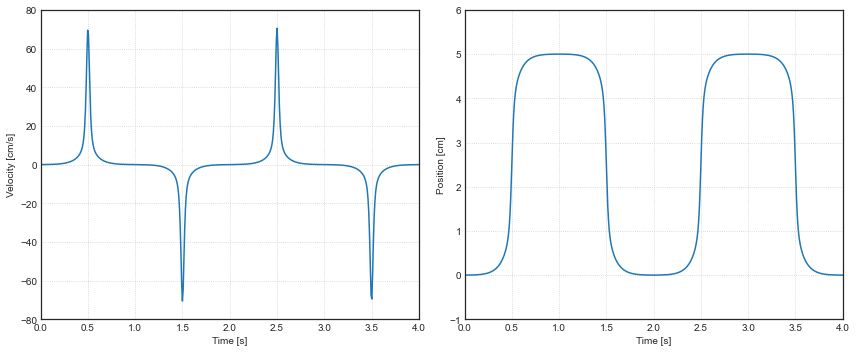

In [7]:
plt.close("all")
plt.style.use("seaborn-white")
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(t, 100 * v)
plt.grid(linestyle=":")
plt.xlabel("Time [s]")
plt.ylabel("Velocity [cm/s]")
plt.xlim(0, t[-1])
plt.ylim(-80, 80)

plt.subplot(122)
plt.plot(t, 100 * x)
plt.grid(linestyle=":")
plt.xlabel("Time [s]")
plt.ylabel("Position [cm]")
plt.xlim(0, t[-1])
plt.ylim(-1, 6)

plt.tight_layout()

Finally we generate the custom C-code for use in some CFD code as an user-defined function.

In [8]:
(c_name, c_code), (h_name, c_header) = \
    codegen(("speed", vt), "C99", header=True, empty=False)

with open(c_name, "w") as fp:
    fp.write(c_code)

with open(h_name, "w") as fp:
    fp.write(c_header)

As you may check below, you probably don't want to implement/check this by hand.

In [9]:
print(c_code)

/******************************************************************************
 *                       Code generated with sympy 1.9                        *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                       This file is part of 'project'                       *
 ******************************************************************************/
#include "speed.h"
#include <math.h>
double speed(double A, double f, double t, double w) {
   double speed_result;
   speed_result = (1.0/2.0)*A*(-2*M_PI*f*sin(2*M_PI*f*t + w)*sin(sin(2*M_PI*f*t + w + sin(sin(2*M_PI*f*t + w + sin(sin(2*M_PI*f*t + w + sin(sin(2*M_PI*f*t + w + sin(sin(2*M_PI*f*t + w + sin(sin(2*M_PI*f*t + w + sin(sin(2*M_PI*f*t + w + sin(2*M_PI*f*t + w)*cos(2*M_PI*f*t + w)))*cos(2*M_PI*f*t + w)))*cos(2*M_PI*f*t + w)))*c

From there you just need to adapt the function interface be called by your simulation tool.